In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kyiv-air-quality-ai-lab-1/saveecobot_16788.csv


In [72]:
import pandas

df = pandas.read_csv("/kaggle/input/kyiv-air-quality-ai-lab-1/saveecobot_16788.csv", on_bad_lines="skip")

/tmp/ipykernel_30/712806620.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pandas.read_csv("/kaggle/input/kyiv-air-quality-ai-lab-1/saveecobot_16788.csv", on_bad_lines="skip")


In [73]:
df

,device_id,phenomenon,value,logged_at,value_text
0,16788,pm10,1.54,2021-03-08 09:27:59,NaN
1,16788,pm25,0.82,2021-03-08 09:27:59,NaN
2,16788,humidity,56.08,2021-03-08 09:27:59,NaN
3,16788,pressure_pa,996648.70,2021-03-08 09:27:59,NaN
4,16788,temperature,1.74,2021-03-08 09:27:59,NaN
...,...,...,...,...,...
2458850,16788,pm10,34.20,2024-09-23 09:26:49,NaN
2458851,16788,pm25,29.50,2024-09-23 09:26:49,NaN
2458852,16788,humidity,18.82,2024-09-23 09:26:49,NaN
2458853,16788,pressure_pa,1006299.10,2024-09-23 09:26:49,NaN


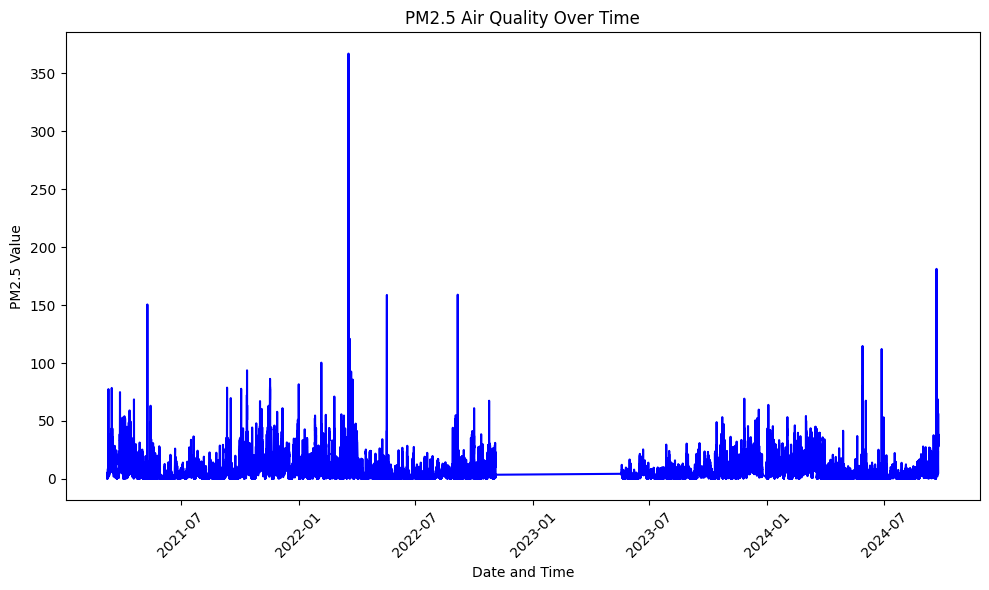

In [74]:
import matplotlib.pyplot as plt

df['logged_at'] = pd.to_datetime(df['logged_at'])
pm25_data = df[df['phenomenon'] == 'pm25']

plt.figure(figsize=(10, 6))
plt.plot(pm25_data['logged_at'], pm25_data['value'], linestyle='-', color='b')
plt.xlabel('Date and Time')
plt.ylabel('PM2.5 Value')
plt.title('PM2.5 Air Quality Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import timedelta

pm25_data['time_numeric'] = pm25_data['logged_at'].map(pd.Timestamp.toordinal)
pm25_data['month'] = pm25_data['logged_at'].dt.month
pm25_data['weekday'] = pm25_data['logged_at'].dt.weekday
pm25_data['one_day_back'] = pm25_data['value'].shift(1)
pm25_data.dropna(subset=['one_day_back'], inplace=True)

# Define features and target
X = pm25_data[['month', 'one_day_back']]
y = pm25_data['value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

/tmp/ipykernel_30/1281087921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25_data['time_numeric'] = pm25_data['logged_at'].map(pd.Timestamp.toordinal)
/tmp/ipykernel_30/1281087921.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25_data['month'] = pm25_data['logged_at'].dt.month
/tmp/ipykernel_30/1281087921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

LinearRegression()

In [96]:
# Prepare future dates and their features
last_date = pm25_data['logged_at'].max()
future_dates = [last_date + timedelta(days=i) for i in range(1, 90)]
future_data = pd.DataFrame({
    'month': [date.month for date in future_dates],
    'weekday': [date.weekday() for date in future_dates],
    'one_day_back': np.nan
})

In [107]:
last_pm25_value = pm25_data['value'].iloc[-1]

# Fill in the one-day-back values iteratively
for i in range(len(future_data)):
    future_data.loc[i, 'one_day_back'] = last_pm25_value
    # Predict the pm25 value and set it as the next one_day_back value
    last_pm25_value = model.predict(future_data.iloc[[i]][['month', 'one_day_back']])[0]
    
predictions = future_data['one_day_back'].values

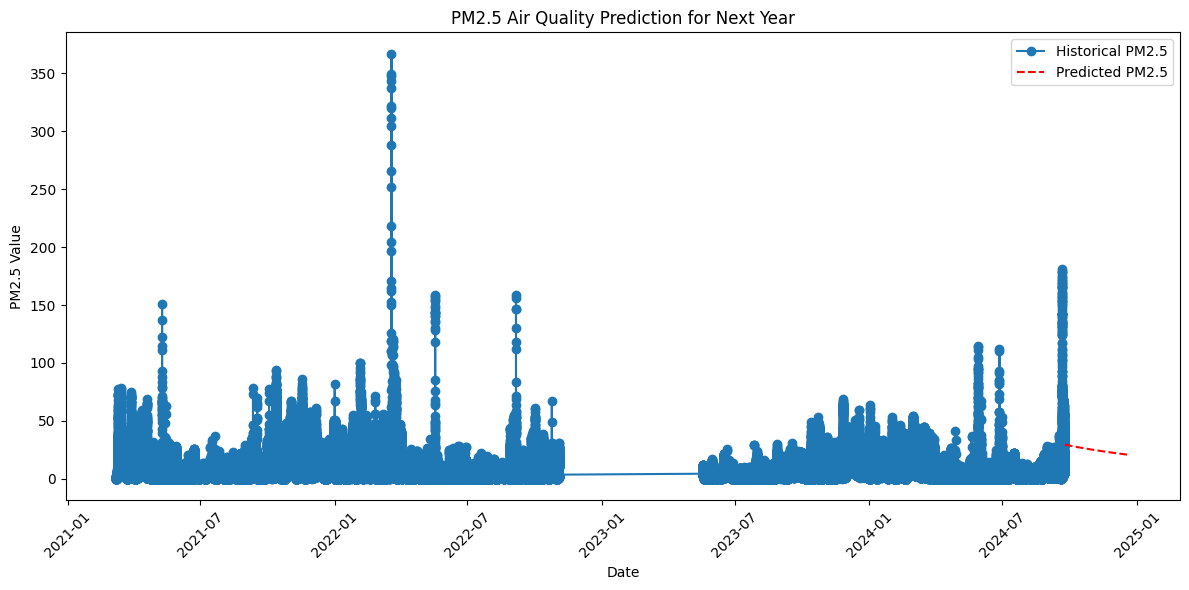

In [108]:
plt.figure(figsize=(12, 6))
plt.plot(pm25_data['logged_at'], pm25_data['value'], label='Historical PM2.5', marker='o')
plt.plot(future_dates, predictions, label='Predicted PM2.5', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('PM2.5 Value')
plt.title('PM2.5 Air Quality Prediction for Next Year')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [113]:
predictions = np.round(predictions, 2)
predictions

array([29.5 , 29.37, 29.24, 29.12, 28.99, 28.86, 28.74, 28.61, 28.49,
       28.37, 28.25, 28.12, 28.  , 27.88, 27.77, 27.65, 27.53, 27.41,
       27.3 , 27.18, 27.07, 26.95, 26.84, 26.72, 26.61, 26.5 , 26.39,
       26.28, 26.17, 26.06, 25.95, 25.85, 25.74, 25.63, 25.53, 25.42,
       25.32, 25.21, 25.11, 25.01, 24.9 , 24.8 , 24.7 , 24.6 , 24.5 ,
       24.4 , 24.31, 24.21, 24.11, 24.01, 23.92, 23.82, 23.73, 23.63,
       23.54, 23.45, 23.35, 23.26, 23.17, 23.08, 22.99, 22.9 , 22.81,
       22.72, 22.63, 22.54, 22.46, 22.37, 22.28, 22.2 , 22.11, 22.03,
       21.94, 21.86, 21.78, 21.7 , 21.61, 21.53, 21.45, 21.37, 21.29,
       21.21, 21.13, 21.05, 20.97, 20.9 , 20.82, 20.74, 20.66])

In [114]:
df = pd.DataFrame({
    'ID': range(1, len(predictions) + 1),
    'predicted_pm25': predictions,
})

# Save to CSV
df.to_csv('output.csv', index=False)